In [4]:

import pandas as pd
from sentence_transformers import SentenceTransformer
from scipy.stats import pearsonr
from torch.nn import functional as F
import torch

train_data = pd.read_csv('/kaggle/input/dataset-3/train.csv', sep='\t')
val_data = pd.read_csv('/kaggle/input/dataset-3/dev.csv', sep='\t')

print("Train data shape before filtering:", train_data.shape)
print("Validation data shape before filtering:", val_data.shape)

train_data = train_data.dropna()
train_data = train_data.reset_index()
val_data = val_data.dropna()
val_data = val_data.reset_index()

print("Train data shape after filtering:", train_data.shape)
print("Validation data shape after filtering:", val_data.shape)

Train data shape before filtering: (5711, 3)
Validation data shape before filtering: (1470, 3)
Train data shape after filtering: (5708, 4)
Validation data shape after filtering: (1468, 4)


In [2]:
# !pip install -U sentence_transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 9.7 MB/s eta 0:00:00


In [6]:
# BERTmodel = SentenceTransformer("all-MiniLM-L6-v2")

# val_sentence1 = val_data['sentence1']
# val_sentence2 = val_data['sentence2']

# BERT_embeddings1 = BERTmodel.encode(val_sentence1)
# BERT_embeddings2 = BERTmodel.encode(val_sentence2)

# cosine_similarities = []
# for i in range(len(BERT_embeddings2)):
#     embedding1_tensor = torch.from_numpy(BERT_embeddings1[i])
#     embedding2_tensor = torch.from_numpy(BERT_embeddings2[i])
    
#     cosine_similarity = F.cosine_similarity(embedding1_tensor, embedding2_tensor, dim=0)
    
#     cosine_similarities.append(cosine_similarity)

# target= val_data['score']

# pearson_corr, _ = pearsonr(cosine_similarities, target)

# print(f"Zero-shot Pearson Coefficient {pearson_corr}")

In [7]:
# from sentence_transformers.evaluation import SentenceEvaluator
# class CustomEvaluator(SentenceEvaluator):
#     def __init__(self, val_data,model):
#         super().__init__()
#         self.model = model
#         self.val_data = val_data
    
#     def __call__(self, model, output_path, epoch, steps):
#         val_sentence1 = self.val_data['sentence1'].tolist()
#         val_sentence2 = self.val_data['sentence2'].tolist()
#         BERT_embeddings1 = BERTmodel.encode(val_sentence1,convert_to_tensor=True)
#         BERT_embeddings2 = BERTmodel.encode(val_sentence2,convert_to_tensor=True)

#         cosine_similarities = []
#         for i in range(len(BERT_embeddings2)):
#             embedding1_tensor = torch.from_numpy(BERT_embeddings1[i])
#             embedding2_tensor = torch.from_numpy(BERT_embeddings2[i])
#             cosine_similarity = F.cosine_similarity(embedding1_tensor, embedding2_tensor, dim=0)
#             cosine_similarities.append(cosine_similarity)
#         target = self.val_data['score'].tolist()


#         pearson_corr, not_needed= pearsonr(cosine_similarities, target)
        

#         return pearson_corr
    


In [8]:
from sentence_transformers.evaluation import SentenceEvaluator

class CustomEvaluator(SentenceEvaluator):
    def __init__(self, model, validation_data):
        self.model = model
        self.validation_data = validation_data

    def __call__(self, model, output_path, epoch, steps):
        sentence1 = self.validation_data['sentence1'].tolist()
        sentence2 = self.validation_data['sentence2'].tolist()
        embeddings1 = model.encode(sentence1, convert_to_tensor=True)
        embeddings2 = model.encode(sentence2, convert_to_tensor=True)

        # Calculate cosine similarities
#         cosine_similarities = [1 - cosine(embeddings1[i].cpu().numpy(), embeddings2[i].cpu().numpy()) for i in range(len(embeddings1))]
        cosine_similarities=[F.cosine_similarity(torch.from_numpy(embeddings1[i].cpu().numpy()),torch.from_numpy(embeddings2[i].cpu().numpy()),dim=0) for i in range(len(embeddings1))]

        target_similarities = self.validation_data['score'].tolist()

        pearson_corr, _ = pearsonr(cosine_similarities, target_similarities)

        print(f"Epoch: {epoch+1}, Steps: {steps}, Pearson Coefficient: {pearson_corr}")
        return pearson_corr

In [9]:
from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader
from torch import nn
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from transformers import get_linear_schedule_with_warmup

In [10]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_examples = []
for index, row in train_data.iterrows():
    texts = [row['sentence1'], row['sentence2']]
    label = row['score']
    input_example = InputExample(texts=texts, label=label)
    train_examples.append(input_example)

# Creating list of InputExample objects for validation data
val_examples = []
for index, row in val_data.iterrows():
    texts = [row['sentence1'], row['sentence2']]
    label = row['score']
    input_example = InputExample(texts=texts, label=label)
    val_examples.append(input_example)

train_dataloader = DataLoader(train_examples, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_examples, batch_size=64, shuffle=True)

def custom_loss_transformation(x):
    y = ((x + 1) / 2) * 5
    return y

BERTmodel = SentenceTransformer("all-MiniLM-L6-v2")
loss_fct = nn.CrossEntropyLoss()

epochs = 20
train_loss_fn = losses.CosineSimilarityLoss(BERTmodel, loss_fct=loss_fct, cos_score_transformation=custom_loss_transformation)
new_learning_rate = 2e-5  
val_losses = []
train_losses = []
optimizer = torch.optim.AdamW(BERTmodel.parameters(), lr=new_learning_rate)

for epoch in range(epochs):
    BERTmodel.fit(train_objectives=[(train_dataloader, train_loss_fn)],
              epochs=1,
              evaluator=CustomEvaluator(BERTmodel, val_data),
              evaluation_steps=len(train_dataloader),
              optimizer_class=torch.optim.AdamW,
              optimizer_params={'lr': 2e-4},
              weight_decay=0.001
             )
    
    train_dataloader = DataLoader(train_examples, batch_size=64, shuffle=True, collate_fn=BERTmodel.smart_batching_collate)
    train_loss = 0
    val_dataloader = DataLoader(val_examples, batch_size=64, shuffle=True, collate_fn=BERTmodel.smart_batching_collate)
    val_loss = 0
    
    BERTmodel.eval()
    with torch.no_grad():
        for batch in tqdm(train_dataloader):
            for sentence_feature in batch[0]:
                sentence_feature['input_ids'], sentence_feature['token_type_ids'], sentence_feature['attention_mask'] = sentence_feature['input_ids'].to(device), sentence_feature['token_type_ids'].to(device), sentence_feature['attention_mask'].to(device)
            loss = train_loss_fn(batch[0], batch[1].to(device))
            train_loss += loss

    BERTmodel.eval()
    with torch.no_grad():
        for batch in tqdm(val_dataloader):
            for sentence_feature in batch[0]:
                sentence_feature['input_ids'], sentence_feature['token_type_ids'], sentence_feature['attention_mask'] = sentence_feature['input_ids'].to(device), sentence_feature['token_type_ids'].to(device), sentence_feature['attention_mask'].to(device)
            loss = train_loss_fn(batch[0], batch[1].to(device))
            val_loss += loss
    


    train_loss = train_loss / len(train_dataloader)
    val_loss = val_loss / len(val_dataloader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f"Epoch: {epoch+1} Training Loss: {train_loss} Validation Loss: {val_loss}")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/90 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 1, Steps: 90, Pearson Coefficient: 0.8663674956467107


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 1, Steps: -1, Pearson Coefficient: 0.8663674956467107


100%|██████████| 23/23 [00:01<00:00, 16.79it/s]

Epoch: 1 Training Loss: 689.7747802734375 Validation Loss: 595.8997802734375


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/90 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 1, Steps: 90, Pearson Coefficient: 0.8688423440855445


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 1, Steps: -1, Pearson Coefficient: 0.8688423440855445


100%|██████████| 23/23 [00:01<00:00, 16.24it/s]

Epoch: 2 Training Loss: 689.48046875 Validation Loss: 595.577392578125


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/90 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 1, Steps: 90, Pearson Coefficient: 0.8710536424867553


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 1, Steps: -1, Pearson Coefficient: 0.8710536424867553


100%|██████████| 23/23 [00:01<00:00, 15.68it/s]

Epoch: 3 Training Loss: 689.1021728515625 Validation Loss: 595.3042602539062


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/90 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 1, Steps: 90, Pearson Coefficient: 0.8727858823867186


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 1, Steps: -1, Pearson Coefficient: 0.8727858823867186


100%|██████████| 23/23 [00:01<00:00, 15.29it/s]


Epoch: 4 Training Loss: 688.8735961914062 Validation Loss: 595.2700805664062


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/90 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 1, Steps: 90, Pearson Coefficient: 0.8741965812139085


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 1, Steps: -1, Pearson Coefficient: 0.8741965812139085


100%|██████████| 23/23 [00:01<00:00, 14.72it/s]

Epoch: 5 Training Loss: 688.5722045898438 Validation Loss: 594.932373046875


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/90 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 1, Steps: 90, Pearson Coefficient: 0.8753085468032302


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 1, Steps: -1, Pearson Coefficient: 0.8753085468032302


100%|██████████| 23/23 [00:01<00:00, 16.92it/s]


Epoch: 6 Training Loss: 688.4553833007812 Validation Loss: 595.0560302734375


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/90 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 1, Steps: 90, Pearson Coefficient: 0.8760251431377718


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 1, Steps: -1, Pearson Coefficient: 0.8760251431377718


100%|██████████| 23/23 [00:01<00:00, 15.58it/s]


Epoch: 7 Training Loss: 688.26708984375 Validation Loss: 594.7352905273438


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/90 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 1, Steps: 90, Pearson Coefficient: 0.8768276214401516


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 1, Steps: -1, Pearson Coefficient: 0.8768276214401516


100%|██████████| 23/23 [00:01<00:00, 17.01it/s]

Epoch: 8 Training Loss: 688.0198364257812 Validation Loss: 594.9099731445312


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/90 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 1, Steps: 90, Pearson Coefficient: 0.8772517798586013


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 1, Steps: -1, Pearson Coefficient: 0.8772517798586013


100%|██████████| 23/23 [00:01<00:00, 15.06it/s]


Epoch: 9 Training Loss: 687.82080078125 Validation Loss: 594.8795776367188


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/90 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 1, Steps: 90, Pearson Coefficient: 0.8774285653566486


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 1, Steps: -1, Pearson Coefficient: 0.8774285653566486


100%|██████████| 23/23 [00:01<00:00, 15.12it/s]

Epoch: 10 Training Loss: 687.8236694335938 Validation Loss: 594.8386840820312


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/90 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 1, Steps: 90, Pearson Coefficient: 0.8777025961198757


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 1, Steps: -1, Pearson Coefficient: 0.8777025961198757


100%|██████████| 23/23 [00:01<00:00, 16.45it/s]

Epoch: 11 Training Loss: 687.4300537109375 Validation Loss: 594.6139526367188


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/90 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 1, Steps: 90, Pearson Coefficient: 0.877814517393591


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 1, Steps: -1, Pearson Coefficient: 0.877814517393591


100%|██████████| 23/23 [00:01<00:00, 15.26it/s]

Epoch: 12 Training Loss: 687.499267578125 Validation Loss: 594.6177978515625


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/90 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 1, Steps: 90, Pearson Coefficient: 0.8775025789434632


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 1, Steps: -1, Pearson Coefficient: 0.8775025789434632


100%|██████████| 23/23 [00:01<00:00, 15.16it/s]


Epoch: 13 Training Loss: 687.3987426757812 Validation Loss: 594.6968383789062


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/90 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 1, Steps: 90, Pearson Coefficient: 0.8775262038036045


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 1, Steps: -1, Pearson Coefficient: 0.8775262038036045


100%|██████████| 23/23 [00:01<00:00, 16.34it/s]


Epoch: 14 Training Loss: 687.0778198242188 Validation Loss: 594.471923828125


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/90 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 1, Steps: 90, Pearson Coefficient: 0.8776425427713951


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 1, Steps: -1, Pearson Coefficient: 0.8776425427713951


100%|██████████| 23/23 [00:01<00:00, 15.14it/s]


Epoch: 15 Training Loss: 687.1915893554688 Validation Loss: 594.60302734375


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/90 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 1, Steps: 90, Pearson Coefficient: 0.8776019929452002


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 1, Steps: -1, Pearson Coefficient: 0.8776019929452002


100%|██████████| 23/23 [00:01<00:00, 16.23it/s]


Epoch: 16 Training Loss: 687.1653442382812 Validation Loss: 594.5572509765625


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/90 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 1, Steps: 90, Pearson Coefficient: 0.8776469953988323


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 1, Steps: -1, Pearson Coefficient: 0.8776469953988323


100%|██████████| 23/23 [00:01<00:00, 15.28it/s]

Epoch: 17 Training Loss: 686.7588500976562 Validation Loss: 594.45703125


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/90 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 1, Steps: 90, Pearson Coefficient: 0.8777638535242439


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 1, Steps: -1, Pearson Coefficient: 0.8777638535242439


100%|██████████| 23/23 [00:01<00:00, 15.12it/s]

Epoch: 18 Training Loss: 686.6592407226562 Validation Loss: 594.3560180664062


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/90 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 1, Steps: 90, Pearson Coefficient: 0.8775328733227225


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 1, Steps: -1, Pearson Coefficient: 0.8775328733227225


100%|██████████| 23/23 [00:01<00:00, 16.36it/s]


Epoch: 19 Training Loss: 686.8526000976562 Validation Loss: 594.689453125


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/90 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 1, Steps: 90, Pearson Coefficient: 0.8772844899317083


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 1, Steps: -1, Pearson Coefficient: 0.8772844899317083


100%|██████████| 23/23 [00:01<00:00, 15.45it/s]

Epoch: 20 Training Loss: 686.6201171875 Validation Loss: 594.339111328125


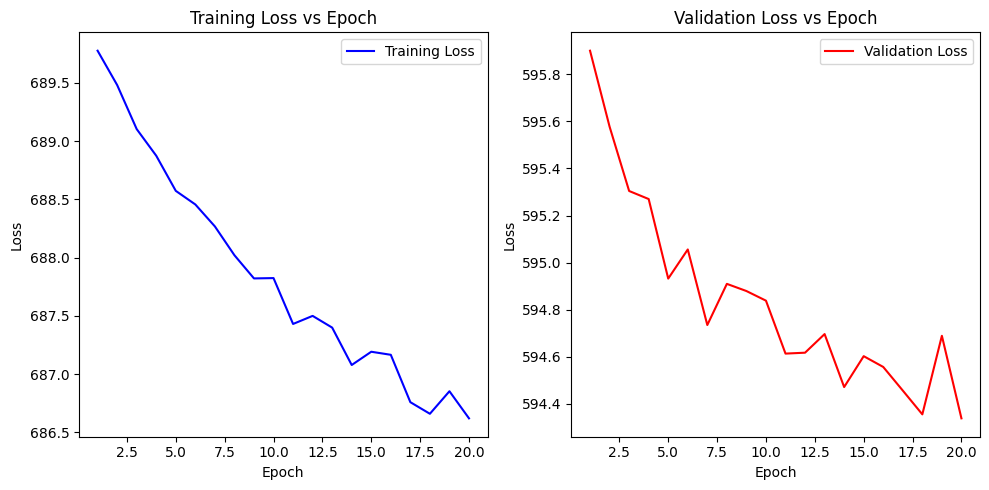

In [12]:
import matplotlib.pyplot as plt
import torch

# Assuming train_losses and val_losses are tensors
train_losses = [x.item() if torch.is_tensor(x) else x for x in train_losses]
val_losses = [x.item() if torch.is_tensor(x) else x for x in val_losses]

# Save the model
torch.save(BERTmodel, 'bert_model.pt')

# Plotting training and validation losses
plt.figure(figsize=(10, 5))

# Plotting training loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Epoch')
plt.legend()

# Plotting validation loss
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss vs Epoch')
plt.legend()

plt.tight_layout()
plt.savefig("/kaggle/working/plot.jpg")


In [28]:
import torch
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertModel
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
# Check if GPU is available and set device accordingly
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


import pandas as pd
from sentence_transformers import SentenceTransformer
from scipy.stats import pearsonr
from torch.nn import functional as F
import torch

train_data = pd.read_csv('/kaggle/input/dataset-3/train.csv', sep='\t')
val_data = pd.read_csv('/kaggle/input/dataset-3/dev.csv', sep='\t')

print("Train data shape before filtering:", train_data.shape)
print("Validation data shape before filtering:", val_data.shape)

train_data = train_data.dropna()
train_data = train_data.reset_index()
val_data = val_data.dropna()
val_data = val_data.reset_index()

print("Train data shape after filtering:", train_data.shape)
print("Validation data shape after filtering:", val_data.shape)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')



There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB
Train data shape before filtering: (5711, 3)
Validation data shape before filtering: (1470, 3)
Train data shape after filtering: (5708, 4)
Validation data shape after filtering: (1468, 4)


In [29]:

# Custom dataset class
class SimilarityDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data
        self.sentences1 = []
        self.sentences2 = []
        self.scores = []

        for _, row in data.iterrows():
            if row['sentence1'] and row['sentence2'] and row['score']:
                self.sentences1.append(str(row['sentence1']))
                self.sentences2.append(str(row['sentence2']))
                self.scores.append(row['score'])

    def __len__(self):
        return len(self.sentences1)

    def __getitem__(self, idx):
        sentence1 = self.sentences1[idx]
        sentence2 = self.sentences2[idx]
        score = self.scores[idx]
        encoding = tokenizer.encode_plus(sentence1, sentence2, padding='max_length', max_length=128, truncation=True, return_tensors='pt')
        input_ids = encoding['input_ids'].squeeze(0)  # Remove the extra dimension
        attention_mask = encoding['attention_mask'].squeeze(0)  # Remove the extra dimension
        return input_ids, attention_mask, score

# Create datasets and data loaders
train_dataset = SimilarityDataset(train_data)
val_dataset = SimilarityDataset(val_data)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)
print(train_dataloader)
print(val_dataloader)


In [30]:
print()
# Custom model class
class BertForSimilarity(torch.nn.Module):
    def __init__(self):
        super(BertForSimilarity, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = torch.nn.Dropout(0.3)
        self.fc = torch.nn.Linear(768, 1)
        self.double()

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        output = self.fc(pooled_output)
        return output

# Initialize model, optimizer, and loss function
model = BertForSimilarity().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.MSELoss()


In [31]:
def train(epochs):
    training_losses = []
    validation_losses = []
    training_pearson_corrs = []
    validation_pearson_corrs = []

    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        print('-' * 10)

        # Training loop
        model.train()
        train_loss = 0.0
        train_pearson_corr = 0.0
        for batch in tqdm(train_dataloader):
            optimizer.zero_grad()
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)
            outputs = model(input_ids, attention_mask).squeeze(1)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # Calculate Pearson correlation coefficient
            pred_scores = outputs.detach().cpu().numpy()
            true_scores = labels.detach().cpu().numpy()
            train_pearson_corr += np.corrcoef(pred_scores, true_scores)[0, 1]

        train_loss /= len(train_dataloader)
        train_pearson_corr /= len(train_dataloader)
        training_losses.append(train_loss)
        training_pearson_corrs.append(train_pearson_corr)

        # Validation loop
        model.eval()
        val_loss = 0.0
        val_pearson_corr = 0.0
        with torch.no_grad():
            for batch in tqdm(val_dataloader):
#                 inputs, labels = batch
#                 input_ids = inputs['input_ids'].to(device)
#                 attention_mask = inputs['attention_mask'].to(device)
#                 labels = labels.to(device)
                input_ids = batch[0].to(device)  # Extract input_ids
                attention_mask = batch[1].to(device)  # Extract attention_mask
                labels = batch[2].to(device)  #
                outputs = model(input_ids, attention_mask).squeeze(1)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()

                # Calculate Pearson correlation coefficient
                pred_scores = outputs.detach().cpu().numpy()
                true_scores = labels.detach().cpu().numpy()
                val_pearson_corr += np.corrcoef(pred_scores, true_scores)[0, 1]

        val_loss /= len(val_dataloader)
        val_pearson_corr /= len(val_dataloader)
        validation_losses.append(val_loss)
        validation_pearson_corrs.append(val_pearson_corr)

        print(f'Training Loss: {train_loss:.4f}')
        print(f'Validation Loss: {val_loss:.4f}')
        print(f'Training Pearson Correlation: {train_pearson_corr:.4f}')
        print(f'Validation Pearson Correlation: {val_pearson_corr:.4f}')

    return training_losses, validation_losses, training_pearson_corrs, validation_pearson_corrs

In [32]:
epochs = 15
training_losses, validation_losses, training_pearson_corrs, validation_pearson_corrs = train(epochs)

Epoch 1/15
----------


 79%|███████▊  | 33/42 [00:08<00:02,  3.96it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
100%|██████████| 42/42 [00:10<00:00,  3.97it/s]


Training Loss: 1.5250
Validation Loss: 0.7383
Training Pearson Correlation: 0.4848
Validation Pearson Correlation: 0.8061
Epoch 2/15
----------


100%|██████████| 42/42 [00:10<00:00,  4.01it/s]


Training Loss: 0.6209
Validation Loss: 0.6603
Training Pearson Correlation: 0.8105
Validation Pearson Correlation: 0.8244
Epoch 3/15
----------


100%|██████████| 42/42 [00:10<00:00,  4.01it/s]


Training Loss: 0.4147
Validation Loss: 0.5660
Training Pearson Correlation: 0.8809
Validation Pearson Correlation: 0.8356
Epoch 4/15
----------


100%|██████████| 42/42 [00:10<00:00,  4.00it/s]


Training Loss: 0.3062
Validation Loss: 0.5608
Training Pearson Correlation: 0.9122
Validation Pearson Correlation: 0.8354
Epoch 5/15
----------


100%|██████████| 42/42 [00:10<00:00,  4.00it/s]


Training Loss: 0.2278
Validation Loss: 0.5601
Training Pearson Correlation: 0.9345
Validation Pearson Correlation: 0.8362
Epoch 6/15
----------


100%|██████████| 42/42 [00:10<00:00,  4.01it/s]


Training Loss: 0.1825
Validation Loss: 0.5591
Training Pearson Correlation: 0.9480
Validation Pearson Correlation: 0.8413
Epoch 7/15
----------


100%|██████████| 42/42 [00:10<00:00,  4.02it/s]


Training Loss: 0.1449
Validation Loss: 0.5781
Training Pearson Correlation: 0.9596
Validation Pearson Correlation: 0.8349
Epoch 8/15
----------


100%|██████████| 42/42 [00:10<00:00,  3.98it/s]


Training Loss: 0.1313
Validation Loss: 0.5547
Training Pearson Correlation: 0.9636
Validation Pearson Correlation: 0.8380
Epoch 9/15
----------


 82%|████████▏ | 137/167 [01:35<00:20,  1.43it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
100%|██████████| 42/42 [00:10<00:00,  4.01it/s]


Training Loss: 0.1110
Validation Loss: 0.5809
Training Pearson Correlation: 0.9690
Validation Pearson Correlation: 0.8386
Epoch 10/15
----------


100%|██████████| 42/42 [00:10<00:00,  4.01it/s]


Training Loss: 0.1010
Validation Loss: 0.5565
Training Pearson Correlation: 0.9721
Validation Pearson Correlation: 0.8441
Epoch 11/15
----------


100%|██████████| 42/42 [00:10<00:00,  3.99it/s]


Training Loss: 0.0895
Validation Loss: 0.5953
Training Pearson Correlation: 0.9757
Validation Pearson Correlation: 0.8442
Epoch 12/15
----------


 14%|█▍        | 6/42 [00:01<00:09,  3.98it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
100%|██████████| 42/42 [00:10<00:00,  4.01it/s]


Training Loss: 0.0864
Validation Loss: 0.5652
Training Pearson Correlation: 0.9766
Validation Pearson Correlation: 0.8442
Epoch 13/15
----------


100%|██████████| 42/42 [00:10<00:00,  4.00it/s]


Training Loss: 0.0789
Validation Loss: 0.5448
Training Pearson Correlation: 0.9785
Validation Pearson Correlation: 0.8407
Epoch 14/15
----------


 79%|███████▊  | 33/42 [00:08<00:02,  3.98it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
100%|██████████| 42/42 [00:10<00:00,  4.00it/s]


Training Loss: 0.0686
Validation Loss: 0.5620
Training Pearson Correlation: 0.9808
Validation Pearson Correlation: 0.8399
Epoch 15/15
----------


100%|██████████| 42/42 [00:10<00:00,  3.99it/s]

Training Loss: 0.0664
Validation Loss: 0.5360
Training Pearson Correlation: 0.9824
Validation Pearson Correlation: 0.8454


[1.5250101926784307, 0.6209011498734673, 0.41468199150776897, 0.3062077215728999, 0.22783877195303603, 0.18252429581899604, 0.14493576054427434, 0.13134283624819146, 0.11097424129011249, 0.10102805952167655, 0.08949462029078549, 0.0863721382532803, 0.07890961453619166, 0.06863131212915288, 0.06637289634650667]


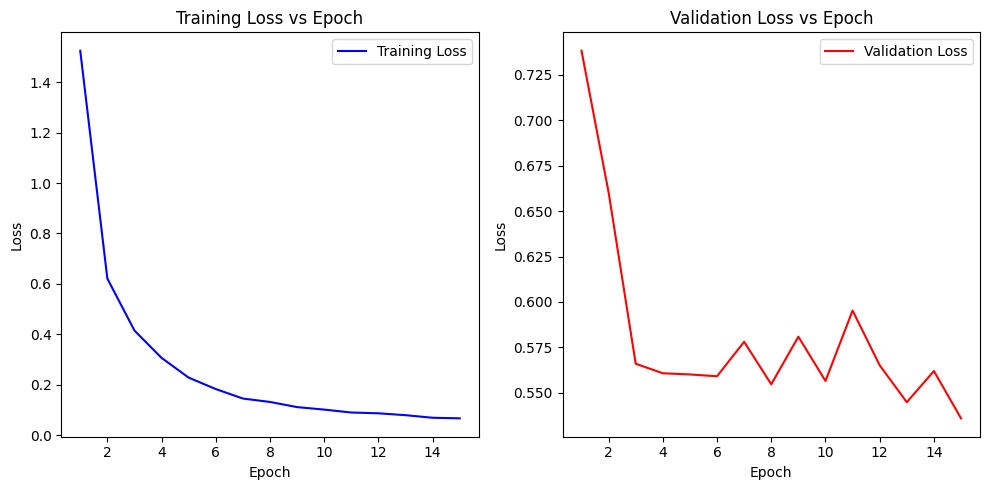

In [33]:

torch.save(model, 'model_1_a.pt')

plt.figure(figsize=(10, 5))
print(training_losses)
# Plotting training loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), training_losses, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Epoch')
plt.legend()

# Plotting validation loss
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), validation_losses , label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss vs Epoch')
plt.legend()

plt.tight_layout()
plt.savefig("/kaggle/working/plot_1_a.jpg")

In [ ]:
print()

In [35]:
%cd /kaggle/working

/kaggle/working


In [37]:
from IPython.display import FileLink
FileLink(r'model_1_a.pt')

/kaggle/working/model_1_a.pt